# Unity ML Agents
## Environment Basics
This notebook contains a walkthrough of the basic functions of the Python API for Unity ML Agents. For instructions on building a Unity environment, see [here](https://github.com/Unity-Technologies/ml-agents/wiki/Getting-Started-with-Balance-Ball).

### 1. Load dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from unityagents import UnityEnvironment

%matplotlib inline

### 2. Set environment parameters

Be sure to set `env_name` to the name of the Unity environment file you want to launch.

In [2]:
env_name = "./GridWorld/GridWorld" # Name of the Unity environment binary to launch
train_mode = True # Whether to run the environment in training or inference mode

### 3. Start the environment
`UnityEnvironment` launches and begins communication with the environment when instantiated.

Environments contain _brains_ which are responsible for deciding the actions of their associated _agents_. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:unityagents.environment:
'GridAcademy' started successfully!


Unity Academy name: GridAcademy
        Number of brains: 1
        Reset Parameters :
		numGoals -> 1.0
		numObstacles -> 1.0
		gridSize -> 4.0
Unity brain name: GridBrain
        Number of observations (per agent): 1
        State space type: continuous
        State space size (per agent): 6
        Action space type: discrete
        Action space size (per agent): 4
        Memory space size (per agent): 0
        Action descriptions: Up, Down, Left, Right


### 4. Examine the observation and state spaces
We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

Agent state looks like: 
[ 0.6  0.2  0.6  0.4  0.6  0.6]
Agent observations look like:


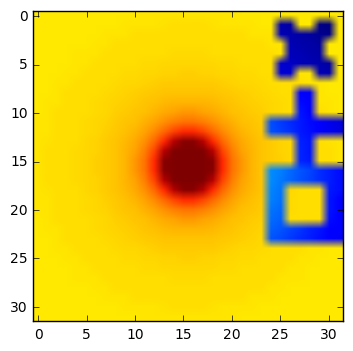

In [4]:
# Reset the environment
env_info = env.reset(train_mode=train_mode)[default_brain]

# Examine the state space for the default brain
print("Agent state looks like: \n{}".format(env_info.states[0]))

# Examine the observation space for the default brain
for observation in env_info.observations:
    print("Agent observations look like:")
    if observation.shape[3] == 3:
        plt.imshow(observation[0,:,:,:])
    else:
        plt.imshow(observation[0,:,:,0])

### 5. Take random actions in the environment
Once we restart an environment, we can step the environment forward and provide actions to all of the agents within the environment. Here we simply choose random actions based on the `action_space_type` of the default brain.

In [5]:
import random

# Initial parameters
Num_Training = 100000
Num_Testing  = 1000 

learning_rate = 0.1
gamma = 0.9
first_epsilon = 1.0
final_epsilon = 0.1

epsilon = first_epsilon

step = 1
score = 0 
episode = 1

# Empty Q table
Q_table = {}


train_mode = True
env_info = env.reset(train_mode=train_mode)[default_brain]
state = env_info.states[0]
state = str(state)

score_list = []
check_show_progress = 0

while True:
    if step <= Num_Training:
        progress = 'Training'
        train_mode = True
        
        # Choose action
        if random.random() < epsilon or state not in Q_table.keys() :
            # Choose random action
            action = np.random.randint(0, brain.action_space_size, size=(len(env_info.agents)))
        else:
            # Choose greedy action
            action = [np.argmax(Q_table[state])]
  
        env_info = env.step(action)[default_brain]

        next_state = env_info.states[0]
        next_state = str(next_state)
        reward = env_info.rewards[0]
        terminal = env_info.local_done[0]
        
        # Decrease epsilon while training
        if epsilon > final_epsilon:
            epsilon -= first_epsilon/Num_Training

    elif step <= Num_Training + Num_Testing:
        progress = 'Testing'
        train_mode = False
        
        # Choose greedy action
        action = [np.argmax(Q_table[state])]

        env_info = env.step(action)[default_brain]

        next_state = env_info.states[0]
        next_state = str(next_state)
        reward = env_info.rewards[0]
        terminal = env_info.local_done[0]
        
        epsilon = 0

    else:
        # Close the environment when learning is finished!
        print('Finished!')
        env.close()
        break

    # Update Q-table!
    if state in Q_table.keys() and next_state in Q_table.keys():
        if terminal == True:
            Q_table[state][action[0]] = (1 - learning_rate) * Q_table[state][action[0]] + learning_rate * (reward)
        else:
            Q_table[state][action[0]] = (1 - learning_rate) * Q_table[state][action[0]] + learning_rate * (reward + gamma * max(Q_table[next_state]))


    # If state or next state is not in Q-table, then add it with zeros
    if state not in Q_table.keys():
        Q_table[state] = []
        for i in range(brain.action_space_size):
            Q_table[state].append(0)
    elif next_state not in Q_table.keys():
        Q_table[next_state] = []
        for i in range(brain.action_space_size):
            Q_table[next_state].append(0)		

    state = next_state
    score += env_info.rewards[0]
    step += 1

       
    # If terminal
    if terminal == True:
        score_list.append(score)
        
        check_show_progress = 1
        episode += 1
        score = 0

        # If game is finished, initialize the state
        env_info = env.reset(train_mode=train_mode)[default_brain]
        state = env_info.states[0]
        state = str(state)
        
    # Show Progress
    if episode % 100 == 0 and check_show_progress == 1:
        print('Step: ' + str(step) + ' / ' + 'Episode: ' + str(episode) + ' / ' + 'Progress: ' + progress + ' / ' + 'Epsilon: ' + str(epsilon) + ' / ' + 'Avg Score: ' + str(np.mean(score_list)))
        score_list = []
        check_show_progress = 0

Step: 1681 / Episode: 100 / Progress: Training / Epsilon: 0.9832000000000765 / Avg Score: -0.0789898989899
Step: 3295 / Episode: 200 / Progress: Training / Epsilon: 0.9670600000001499 / Avg Score: -0.0815
Step: 4546 / Episode: 300 / Progress: Training / Epsilon: 0.9545500000002068 / Avg Score: -0.1452
Step: 6078 / Episode: 400 / Progress: Training / Epsilon: 0.9392300000002766 / Avg Score: -0.0632
Step: 7545 / Episode: 500 / Progress: Training / Epsilon: 0.9245600000003433 / Avg Score: -0.0367
Step: 9049 / Episode: 600 / Progress: Training / Epsilon: 0.9095200000004118 / Avg Score: -0.0105
Step: 10375 / Episode: 700 / Progress: Training / Epsilon: 0.8962600000004721 / Avg Score: -0.1527
Step: 11689 / Episode: 800 / Progress: Training / Epsilon: 0.8831200000005319 / Avg Score: -0.0614
Step: 13056 / Episode: 900 / Progress: Training / Epsilon: 0.8694500000005941 / Avg Score: -0.0067
Step: 14458 / Episode: 1000 / Progress: Training / Epsilon: 0.8554300000006579 / Avg Score: -0.0702
Step: 